# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8)

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=5)
    
- `Strong Augment`: CutMix(patch=2)
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: None
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [1]:
!pip install -q tensorflow==2.15.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
import os
import gc
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None
LOAD_SEGMENTATION_FROM = '/kaggle/input/cxr-unet/'

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-10-10 08:01:45.554204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 08:01:45.554276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 08:01:45.555676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')
tf.config.optimizer.set_jit(True)


Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Load and Read Data</b></div>

In [4]:
df = pd.read_csv('/kaggle/input/pc-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle','input','pc-dataset','lung_diseases','*','*.png'))}
df['path'] = df['Image Index'].map(tmp)
print(df.columns)

### Final
df_all = []
label_counts = df['Finding Labels'].value_counts()

for label in ['No Finding','Atelectasis','Pneumonia','Effusion','Emphysema','Edema','Consolidation','Fibrosis','Cardiomegaly','Pneumothorax']:
    n = min(500, (df['Finding Labels'] == label).sum())
    df_all.append(df[df['Finding Labels'] == label].sample(n=n, random_state=42))

df = pd.concat(df_all)
df = df.reset_index(drop=True)

Index(['Image Index', 'Patient ID', 'View Position', 'Finding Labels',
       'Patient Age', 'path'],
      dtype='object')


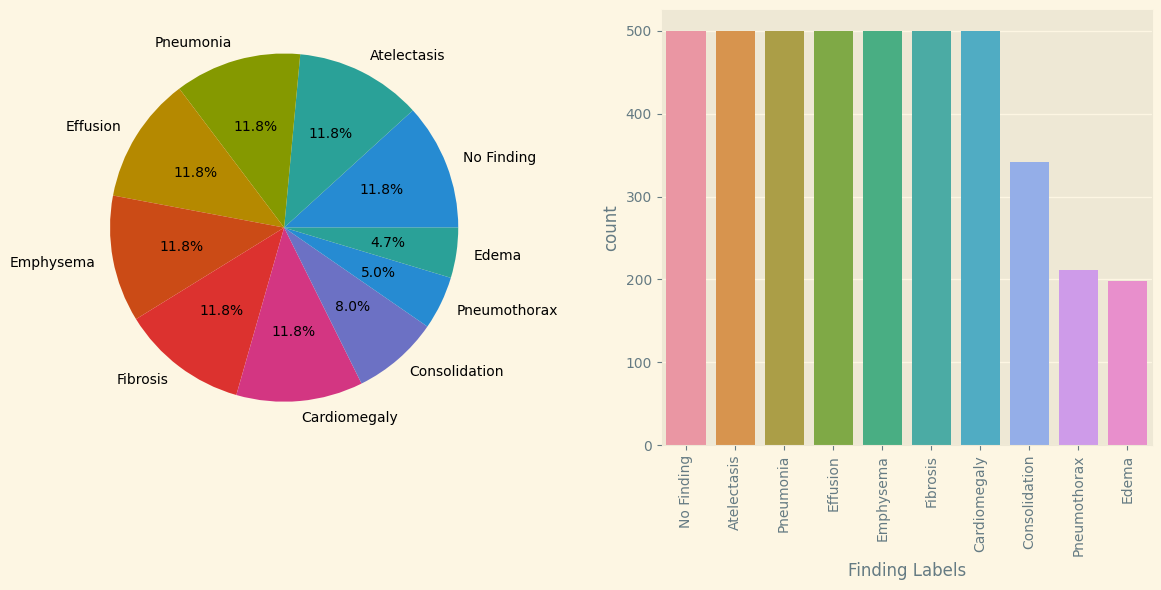

In [5]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**One Hot Encoding**

In [6]:
df = df[~df['Finding Labels'].str.contains('\|')]
df = df.reset_index(drop=True)

In [7]:
for label in df['Finding Labels'].unique():
    df[label] = df['Finding Labels'].apply(lambda x: 1.0 if x == label else 0).astype('float32')

TARGET = df.columns[-10:]

In [8]:
TARGET

Index(['No Finding', 'Atelectasis', 'Pneumonia', 'Effusion', 'Emphysema',
       'Edema', 'Consolidation', 'Fibrosis', 'Cardiomegaly', 'Pneumothorax'],
      dtype='object')

In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['Finding Labels'] = label_encoder.fit_transform(df['Finding Labels'])

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build DataGenerator</b></div>

In [11]:
import albumentations as albu
print(albu.__version__)

1.4.17


In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None, mode='regular'):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


    def __len__(self):
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y

    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):

        X = np.zeros((len(indexes),256,256,3), dtype='float32')
        if self.mode == 'regular': y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        else: y = np.zeros((len(indexes),1), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']

            img = np.array(Image.open(path))
            img = (img / 65536.0 * 255).astype(np.uint8)
            img = Image.fromarray(img)
            img = img.resize((256,256), Image.Resampling.LANCZOS)
            img = np.array(img)
            img = img.astype(np.uint8)

            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j,:,:,:3] = img
            if self.mode == 'regular': y[j,] = row[TARGET]
            else: y[j,] = row['Finding Labels']

        return X,y


    def __augment1(self, img_batch):

        composition = albu.Compose([
                 albu.OneOf([albu.HorizontalFlip(p=1.0)], p=0.5),
                 albu.OneOf([albu.Rotate(limit=5, p=1.0)], p=0.5),
        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(2.0, 2.0)

                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]

        return img_batch

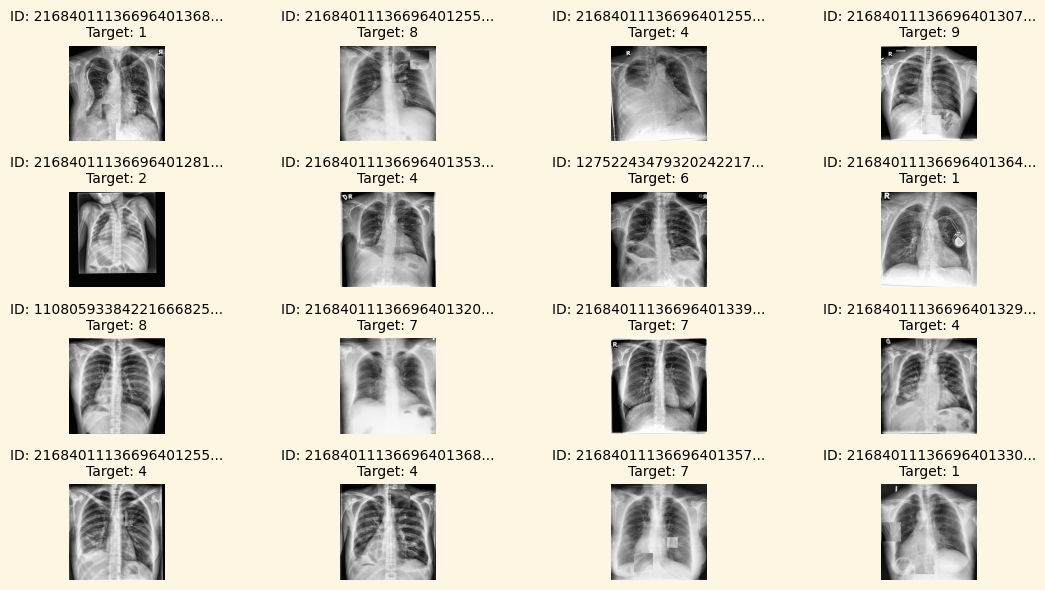

In [13]:
ROWS = 4; COLS = 4; BATCHES = 1


gen = DataGenerator(df_train,batch_size=16, shuffle=False, augment1=True, augment2=True, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id[:20] + ("..." if len(img_id) > 20 else "")}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

### install efficientnet

In [14]:
!pip install -q -U git+https://github.com/qubvel/efficientnet

import efficientnet.tfkeras as efn

## 0. Encoder (eff_model~GAP layer)

In [15]:
def create_encoder():
    inp = layers.Input(shape=(256,256,3))
    eff_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    eff_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')

    eff_out = eff_model(inp)
    x = layers.GlobalAveragePooling2D()(eff_out)

    model = Model(inputs=inp, outputs=x, name='encoder')

    return model

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Classifier (EfficientNet b0)</b></div>

In [16]:
!pip install -q umap-learn

## 1. Classifier (Encoder + Dense layer)

In [17]:
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(df_train, groups=df_train['Patient ID'])):
    df_train.loc[valid_index, 'Fold'] = i


Fold 1
 1/14 [=>............................] - ETA: 1:29

I0000 00:00:1728547362.486925      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - 22s 1s/step
Macro AUC for Initial Classifier: 0.867934831411203



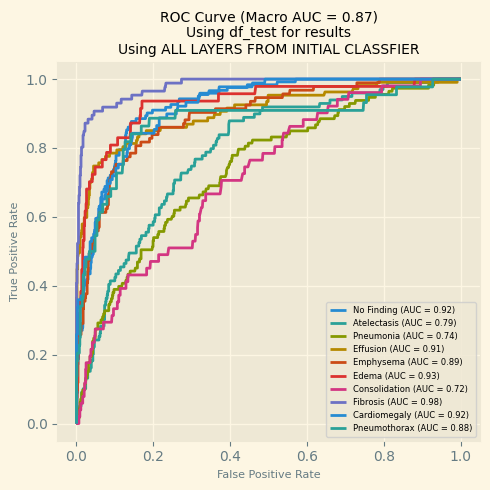

Fold 1
54/54 [==============================] - 61s 1s/step


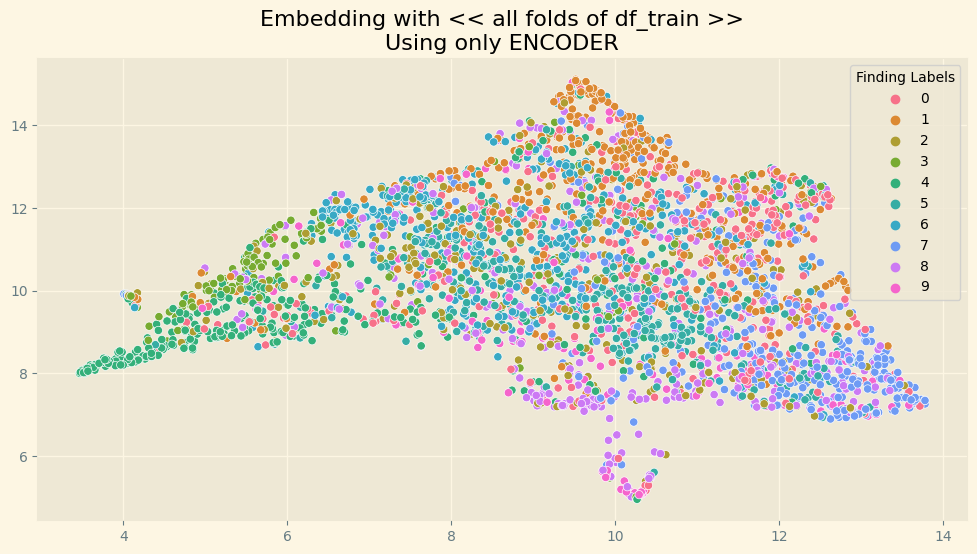

In [18]:
def create_classifier(encoder, trainable=True,ln_r=1e-3):
    inp = layers.Input(shape=(256,256,3))

    for layer in encoder.layers:
        layer.trainable = trainable

    features = encoder(inp)
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(features)

    # Compile
    model = Model(inputs=inp, outputs=x)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=ln_r)
    label_weights = [1.0] * 10
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)

    model.compile(loss=loss, optimizer=opt, metrics=[AUC])

    return model

## Initial classification model -- a) Checking Initial Model
preds = []

for i in range(1):
    print(f'Fold {i+1}')
    K.clear_session()

    encoder = create_encoder()
    model = create_classifier(encoder)
    model.load_weights('/kaggle/input/weights/initial_classifier_f0.weights/initial_classifier_f0.weights.h5')

    test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)

initial_pred = np.mean(preds, axis=0)

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], initial_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_auc = roc_auc_score(df_test[TARGET], initial_pred, average='macro')
print(f'Macro AUC for Initial Classifier: {macro_auc}\n')
plt.figure(figsize=(5,5))
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], label=f'{TARGET[i]} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title(f'ROC Curve (Macro AUC = {macro_auc:.2f})\nUsing df_test for results\nUsing ALL LAYERS FROM INITIAL CLASSFIER', fontsize=10)
plt.legend(loc="lower right", fontsize=6)
plt.tight_layout()
plt.show()


## Initial classification model -- b) EMBEDDING & Visualizing
preds = []

train_gen = DataGenerator(df_train, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}')
    K.clear_session()
    model = create_encoder()
    model.load_weights('/kaggle/input/weights/regular_f0.weights/regular_f0.weights.h5')

    pred = model.predict(train_gen, verbose=1)

    preds.append(pred)
pred = np.mean(preds,axis=0)
train_embedding = pred


train_embedding = pd.DataFrame(train_embedding)
train_embedding.columns = [f'embedding_{i}' for i in range(len(train_embedding.columns))]
train_embedding = pd.concat([df_train.drop(columns=TARGET), train_embedding], axis=1)

import umap.umap_ as umap
umap = umap.UMAP()

plt.figure(figsize=(12,6))
plt.title('Embedding with << all folds of df_train >>\nUsing only ENCODER')
embed_2d = umap.fit_transform(train_embedding.drop(columns=train_embedding.columns[:14]))
sns.scatterplot(x=embed_2d[:,0], y=embed_2d[:,1], hue=train_embedding['Finding Labels'], palette=sns.color_palette("husl", n_colors=10), sizes=2)

plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. Contrast Learning</b></div>

In [19]:
!pip install -q tensorflow-addons

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


## 1) DEFINITION of Supervised Contrastive LOSS

In [20]:
import tensorflow_addons as tfa

In [21]:
class SupervisedContrastiveLoss(losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

## 2. Adding Projection head to the ENCODER

In [22]:
def add_projection_head(encoder, freeze_encoder=False):
    if freeze_encoder:
        for layer in encoder.layers:
            layer.trainable = False
    inp = layers.Input(shape=(256,256,3))
    features = encoder(inp)
    outputs = layers.Dense(128, activation='relu')(features)
    model = Model(inputs=inp, outputs=outputs, name='encoder_with_projection_head')

    return model

## a) Train

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)


In [24]:
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(df_train, groups=df_train['Patient ID'])):
    df_train.loc[valid_index, 'Fold'] = i

print('Composition of LABELS\n', list(TARGET))
for i in range(5):
    fold_data = df_train[df_train['Fold'] == i]
    print(f'Fold: {i+1} | Total: {len(fold_data)} |', *[sum(fold_data['Finding Labels'] == j) for j in range(10)])

Composition of LABELS
 ['No Finding', 'Atelectasis', 'Pneumonia', 'Effusion', 'Emphysema', 'Edema', 'Consolidation', 'Fibrosis', 'Cardiomegaly', 'Pneumothorax']
Fold: 1 | Total: 680 | 96 79 55 30 70 68 81 72 80 49
Fold: 2 | Total: 680 | 99 88 53 35 73 93 69 63 75 32
Fold: 3 | Total: 680 | 70 81 48 39 82 79 87 83 82 29
Fold: 4 | Total: 680 | 66 79 67 18 87 70 108 78 71 36
Fold: 5 | Total: 680 | 70 84 68 29 81 97 69 82 79 21


In [25]:
lr_start = 1e-8
lr_min = 1e-8
lr_max = 1e-4
num_cycles = 1.
warmup_epochs = 1
hold_max_epochs = 0
total_epochs = 10
BATCH_SIZE =128
NUM_TRAINING_IMAGES = len(df_train[df_train['Fold'] != 0])  # Adjust this based on your actual training data size
warmup_steps = warmup_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
hold_max_steps = hold_max_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
total_steps = total_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)

@tf.function
def cosine_schedule_with_warmup(step, total_steps, warmup_steps, hold_max_steps, 
                                lr_start, lr_max, lr_min, num_cycles):
    step = tf.cast(step, tf.float32)
    total_steps = tf.cast(total_steps, tf.float32)
    warmup_steps = tf.cast(warmup_steps, tf.float32)
    hold_max_steps = tf.cast(hold_max_steps, tf.float32)
    lr_start = tf.cast(lr_start, tf.float32)
    lr_max = tf.cast(lr_max, tf.float32)
    lr_min = tf.cast(lr_min, tf.float32)
    num_cycles = tf.cast(num_cycles, tf.float32)

    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)
    return lr

class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, total_steps, warmup_steps, hold_max_steps, lr_start, lr_max, lr_min, num_cycles):
        super().__init__()
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.hold_max_steps = hold_max_steps
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.num_cycles = num_cycles

    def __call__(self, step):
        return cosine_schedule_with_warmup(step, self.total_steps, self.warmup_steps, self.hold_max_steps,
                                           self.lr_start, self.lr_max, self.lr_min, self.num_cycles)


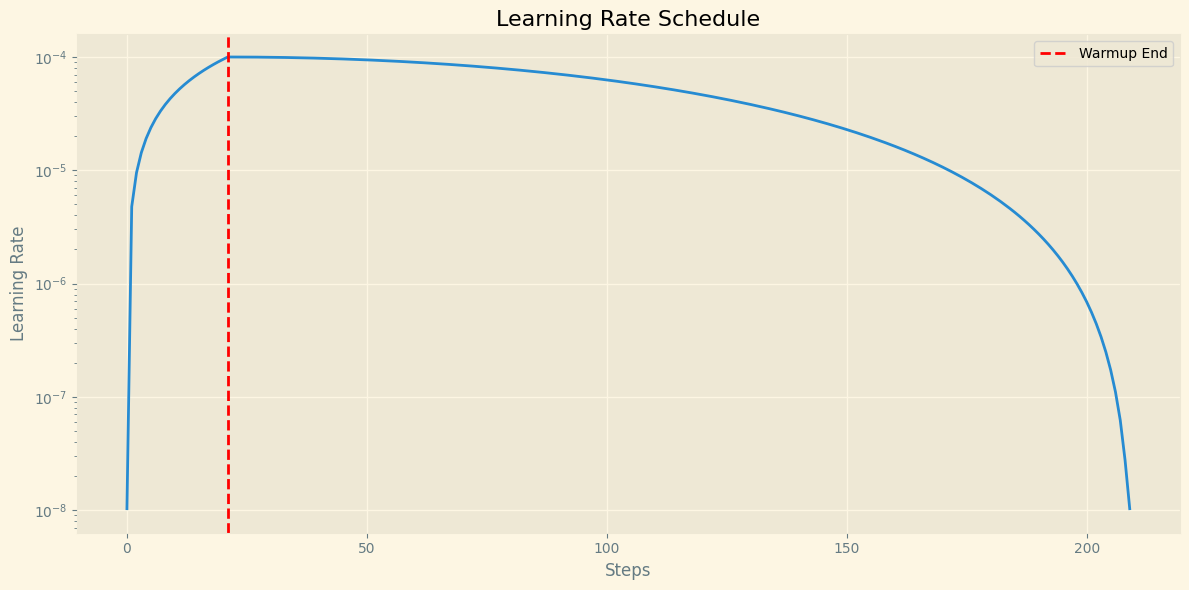

In [26]:
# LR 스케줄 함수 정의
def lr_schedule(step):
    return cosine_schedule_with_warmup(
        step, total_steps, warmup_steps, hold_max_steps,
        lr_start, lr_max, lr_min, num_cycles
    ).numpy()

# 스텝 생성
steps = np.arange(0, total_steps, 1)

# LR 값 계산
lr_values = [lr_schedule(step) for step in steps]

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(steps, lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.yscale('log')  # y축을 로그 스케일로 설정
plt.grid(True)

# Warmup 구간 표시
plt.axvline(x=warmup_steps, color='r', linestyle='--', label='Warmup End')

plt.legend()
plt.tight_layout()
plt.show()

In [27]:
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from collections import defaultdict
import gc

all_history = defaultdict(list)

for i in range(1):
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=128, mode='contrast', preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=256, mode='contrast', preprocess=efn.preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        encoder = create_encoder()
        encoder.load_weights('/kaggle/input/weights/regular_f0.weights/regular_f0.weights.h5')
        encoder_with_projection_head = add_projection_head(encoder)
        encoder_with_projection_head.summary()
        
        lr_schedule = WarmupCosineDecay(total_steps, warmup_steps, hold_max_steps, lr_start, lr_max, lr_min, num_cycles)
        optimizer = optimizers.Adam(learning_rate=lr_schedule)
        
        encoder_with_projection_head.compile(optimizer=optimizer, 
                                             loss=SupervisedContrastiveLoss())
        
        history = encoder_with_projection_head.fit(
            train_gen,
            verbose=1,
            validation_data=valid_gen,
            epochs=EPOCHS,
            callbacks=[es]  # es는 EarlyStopping 콜백이라고 가정
        )
        
        encoder.save_weights(f'contrast_f{i}.weights.h5')
        print(history.history)
        for metric in ['loss', 'val_loss']:
            all_history[metric].append(history.history[metric])
    
    del encoder_with_projection_head, encoder, train_gen, valid_gen
    gc.collect()

#########################
### Fold 1
### train size 2720, valid size 680
#########################
Model: "encoder_with_projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder (Functional)        (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
Total params: 4213532 (16.07 MB)
Trainable params: 4171516 (15.91 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 127s 2s/step - loss: 4.0302 - val_loss: 4.6169
Epoch 2/10
22/22 [==============================] - 53s 2s/s

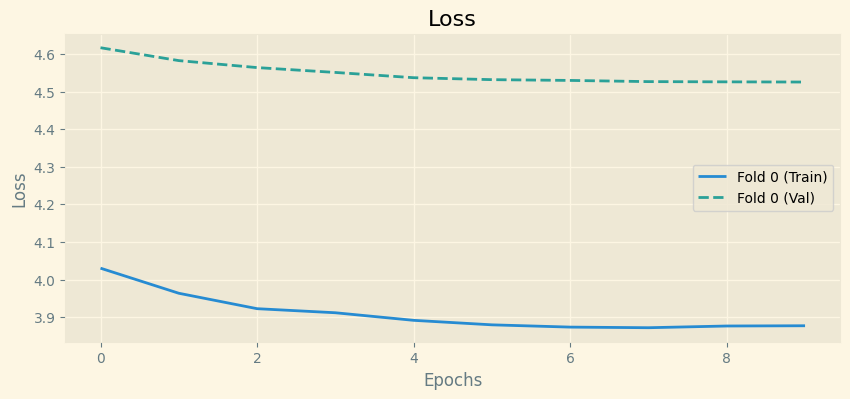

In [28]:
plt.figure(figsize=(10, 4))
plt.title('Loss')
for fold, loss in enumerate(all_history['loss']):
    plt.plot(loss, label=f'Fold {fold} (Train)')
for fold, val_loss in enumerate(all_history['val_loss']):
    plt.plot(val_loss, label=f'Fold {fold} (Val)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


## b) Embedding

In [29]:
preds = []

train_gen = DataGenerator(df_train, shuffle=False, batch_size=64, preprocess=efn.preprocess_input, mode='contrast')

for i in range(1):
    print(f'Fold {i+1}')
    K.clear_session()
    model = create_encoder()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}contrast_f{i}.weights.h5')
    else:
        model.load_weights(f'contrast_f{i}.weights.h5')

    pred = model.predict(train_gen, verbose=1)

    preds.append(pred)
pred = np.mean(preds,axis=0)
train_embedding = pred


train_embedding = pd.DataFrame(train_embedding)
train_embedding.columns = [f'embedding_{i}' for i in range(len(train_embedding.columns))]

train_embedding = pd.concat([df_train, train_embedding], axis=1)
train_embedding['Finding Labels'] = train_embedding['Finding Labels'].astype('float32')


Fold 1
54/54 [==============================] - 28s 446ms/step


## c) Visualizing

In [30]:
print(train_embedding['Finding Labels'].value_counts())


Finding Labels
6.0    414
1.0    411
5.0    407
0.0    401
4.0    393
8.0    387
7.0    378
2.0    291
9.0    167
3.0    151
Name: count, dtype: int64


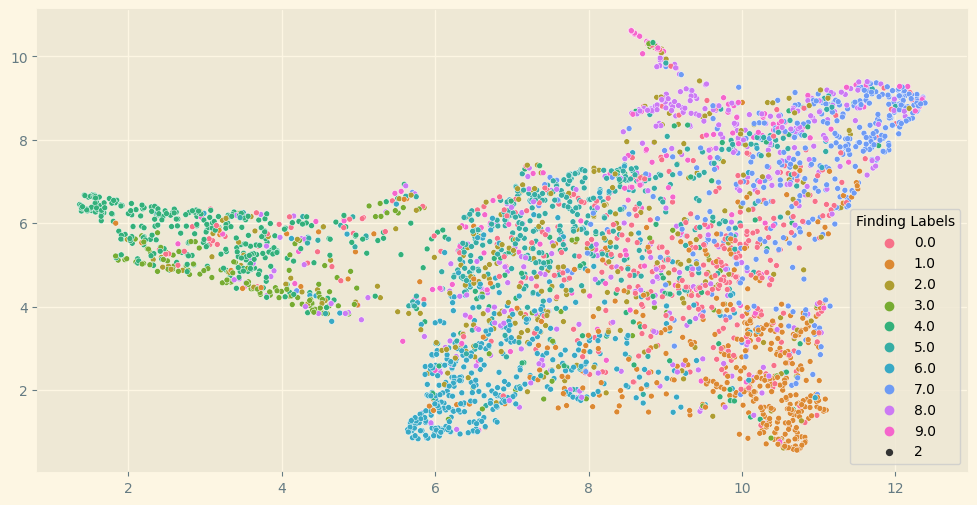


TARGET 1.0-Atelectasis:
  UMAP1 - Mean: 9.6279, SD: 1.6211, RANGE: [1.8334, 11.5335]
  UMAP2 - Mean: 2.8401, SD: 1.5869, RANGE: [0.5555, 8.8953]

TARGET 8.0-Cardiomegaly:
  UMAP1 - Mean: 8.8253, SD: 1.9759, RANGE: [3.3792, 12.3568]
  UMAP2 - Mean: 6.2885, SD: 2.4068, RANGE: [1.0568, 10.3319]

TARGET 4.0-Emphysema:
  UMAP1 - Mean: 4.2193, SD: 2.5496, RANGE: [1.3630, 11.7824]
  UMAP2 - Mean: 5.5381, SD: 1.1832, RANGE: [1.2977, 10.3323]

TARGET 9.0-Pneumothorax:
  UMAP1 - Mean: 8.7645, SD: 1.9982, RANGE: [2.6453, 12.3653]
  UMAP2 - Mean: 7.0500, SD: 2.3469, RANGE: [0.7602, 10.6268]

TARGET 2.0-Pneumonia:
  UMAP1 - Mean: 7.6503, SD: 2.1910, RANGE: [1.9863, 12.1804]
  UMAP2 - Mean: 5.3552, SD: 1.9466, RANGE: [0.6097, 10.2463]

TARGET 6.0-Consolidation:
  UMAP1 - Mean: 6.9215, SD: 1.1603, RANGE: [2.9848, 11.0932]
  UMAP2 - Mean: 2.7613, SD: 1.4899, RANGE: [0.8319, 7.9668]

TARGET 7.0-Fibrosis:
  UMAP1 - Mean: 10.7807, SD: 1.1775, RANGE: [4.1936, 12.3882]
  UMAP2 - Mean: 7.2085, SD: 1.8099, 

In [31]:
%%time
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.figure(figsize=(12,6))
try:
    umap_reducer = umap.UMAP()
    embed_2d = umap_reducer.fit_transform(train_embedding.drop(columns=train_embedding.columns[:14]))
    sns.scatterplot(x=embed_2d[:,0], y=embed_2d[:,1], hue=train_embedding['Finding Labels'], palette=sns.color_palette("husl", n_colors=10), size=2)
    plt.show()

    df_embed = pd.DataFrame(embed_2d, columns=['UMAP1', 'UMAP2'])
    df_embed['Label'] = train_embedding['Finding Labels']

    for label in df_embed['Label'].unique():
        label_data = df_embed[df_embed['Label'] == label]
        print(f"\nTARGET {label}-{TARGET[int(label)]}:")
        for col in ['UMAP1', 'UMAP2']:
            mean = label_data[col].mean()
            std = label_data[col].std()
            min_val = label_data[col].min()
            max_val = label_data[col].max()
            print(f"  {col} - Mean: {mean:.4f}, SD: {std:.4f}, RANGE: [{min_val:.4f}, {max_val:.4f}]")

except ValueError as e:
    print(f"Error during processing UMAP: {e}")
    print(train_embedding.drop(columns=train_embedding.columns[:14]).head(10))

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. FC layer 재학습</b>

### 대조 학습 후 인코더를 로드하고, create_classifier 함수에 trainable=False 매개변수를 전달하여 인코더를 동결대조 학습 후 인코더를 로드하고, create_classifier 함수에 trainable=False 매개변수를 전달하여 인코더를 동결

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 1e-2,
                              mode='max',verbose=1)

In [33]:
import tensorflow.keras.backend as K

all_history = defaultdict(list)

for i in range(1):


    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)

    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        encoder = create_encoder()
        encoder.load_weights(f'contrast_f{i}.weights.h5')
        model = create_classifier(encoder, trainable=True,ln_r=1e-3)
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'effnet_f{i}.weights.h5')
        for metric in ['loss', 'val_loss', 'auc','val_auc','lr']:
            all_history[metric].append(history.history[metric])

    del model, encoder, train_gen, valid_gen
    gc.collect()

#########################
### Fold 1
### train size 2720, valid size 680
#########################
Epoch 1/10
170/170 [==============================] - 121s 236ms/step - loss: 0.3230 - auc: 0.7982 - val_loss: 0.3184 - val_auc: 0.8391 - lr: 0.0010
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.2973 - auc: 0.8517
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
170/170 [==============================] - 34s 201ms/step - loss: 0.2973 - auc: 0.8517 - val_loss: 0.3814 - val_auc: 0.7620 - lr: 0.0010
Epoch 3/10
170/170 [==============================] - 30s 178ms/step - loss: 0.2737 - auc: 0.8973 - val_loss: 0.2732 - val_auc: 0.9036 - lr: 1.0000e-04
Epoch 4/10
170/170 [==============================] - ETA: 0s - loss: 0.2670 - auc: 0.9075
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
170/170 [==============================] - 29s 173ms/step - loss: 0.2670 - auc: 0.9075 - val_loss: 0.2750 - val_auc: 0.9036 - l

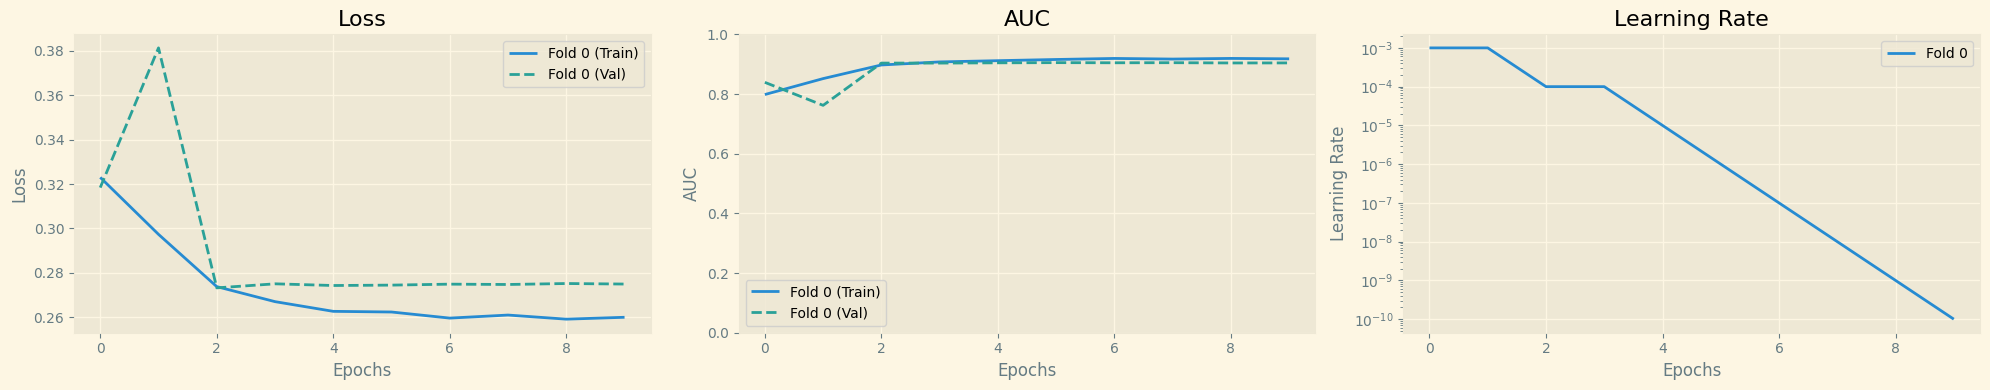

In [34]:
plt.figure(figsize=(20, 4))

# Loss plot
plt.subplot(1, 3, 1)
plt.title('Loss')
for fold, loss in enumerate(all_history['loss']):
    plt.plot(loss, label=f'Fold {fold} (Train)')
for fold, val_loss in enumerate(all_history['val_loss']):
    plt.plot(val_loss, label=f'Fold {fold} (Val)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# AUC plot
plt.subplot(1, 3, 2)
plt.title('AUC')
for fold, auc in enumerate(all_history['auc']):
    plt.plot(auc, label=f'Fold {fold} (Train)')
for fold, val_auc in enumerate(all_history['val_auc']):
    plt.plot(val_auc, label=f'Fold {fold} (Val)', linestyle='--')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Learning Rate plot
plt.subplot(1, 3, 3)
plt.title('Learning Rate')
for fold, lr in enumerate(all_history['lr']):
    plt.plot(lr, label=f'Fold {fold}')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>8. Test</b>

In [35]:
preds = []

for i in range(1):
    test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)
    print(f'Fold {i+1}')
    K.clear_session()
    encoder = create_encoder()
    model = create_classifier(encoder)
    
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}effnet_f{i}.weights.h5')
    else:
        model.load_weights(f'effnet_f{i}.weights.h5')

    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)

final_pred = np.mean(preds, axis=0)

Fold 1
14/14 [==============================] - 12s 585ms/step


Macor AUC for Final Classifier: 0.8763567494749742



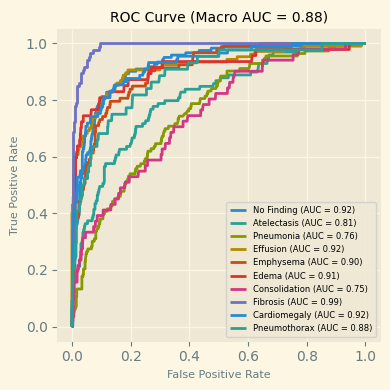

In [36]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], final_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_auc = roc_auc_score(df_test[TARGET], final_pred, average='macro')
print(f'Macor AUC for Final Classifier: {macro_auc}\n')
plt.figure(figsize=(4,4))
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], label=f'{TARGET[i]} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title(f'ROC Curve (Macro AUC = {macro_auc:.2f})', fontsize=10)
plt.legend(loc="lower right", fontsize=6)
plt.tight_layout()
plt.show()